In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/BikeSharingAssignment-LinearRegression

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/BikeSharingAssignment-LinearRegression


In [ ]:
# Imports

!pip install scikit-learn==0.24.1 category_encoders
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import string
import re
from scipy import sparse
from joblib import Parallel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import delayed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# Defining encoder/transformer classes

class FeatureUnionPandas(FeatureUnion):

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
#         from joblib import Parallel
#         from sklearn.utils.fixes import delayed
       
       
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(pipeline._transform_one)(trans, X, None, weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
   
    def fit_transform(self, X, y=None, **fit_params):
       
        results = self._parallel_func(X, y, fit_params, pipeline._fit_transform_one)

        if not results:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        Xs, transformers = zip(*results)
       
        self._update_transformer_list(transformers)
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
  

class AddSquareTerms(BaseEstimator, TransformerMixin):
  def __init__(self, square_variables = None, num_variables = None):
    self.square_variables = square_variables
    self.num_variables = num_variables

  def fit(self, X, y=None):
    None
    return self

  def transform(self, X):
    X = X[self.num_variables].copy()
    for i in self.square_variables:
      X[i+"_sq"] = X[i]**2
    return X


class RareLabelCategoricalEncoder(BaseEstimator, TransformerMixin):
    """Rare label categorical encoder"""

    def __init__(self, variables=None, tol=0.001):
        self.tol = tol
        self.variables = variables

    def fit(self, X, y=None):

        if not isinstance(self.variables, list):
            self.variables = sorted([self.variables])
        else:
            self.variables = sorted(self.variables)
           
        # for compatibility with ColumnTransformer
        if self.variables == [None]:
            self.variables = X.columns
           
        # persist frequent labels in dictionary
        self.encoder_dict_ = {}

        X = X[self.variables].copy()
        for var in self.variables:
            X[var] = X[var].replace(r'^\s*$', np.nan, regex=True).fillna('ZZ').astype('str')
            # the encoder will learn the most frequent categories
            t = pd.Series(X[var].value_counts() / np.float(len(X)))
            # frequent labels:
            self.encoder_dict_[var] = list(t[t >= self.tol].index)

        return self

    def transform(self, X):
        # print("Processing RareLabelCategoricalEncoder at:", round(time.time()/60)%1000, 'minutes')
       
        X = X[self.variables].copy()
        for feature in self.variables:
            X[feature] = X[feature].replace(r'^\s*$', np.nan, regex=True).fillna('ZZ').astype('str')
            X[feature] = np.where(X[feature].isin(self.encoder_dict_[feature]), X[feature], 'Rare')
        return X


class MinMaxScalerPandas(BaseEstimator, TransformerMixin):
   
    def __init__(self):
        None
       
    def fit(self, X, y=None):
       
        self.columns = X.columns
        self.scaler = MinMaxScaler() #RobustScaler(unit_variance=True)
        self.scaler.fit(X)
       
        return self
   
    def transform(self, X):
       
        X = X.copy()
        index = X.index.values
        X = DataFrame(self.scaler.transform(X), index = index, columns = self.columns)
       
        return X

In [4]:
# Reading the data

df_bike = pd.read_csv("day.csv")
df_bike['dteday'] = pd.to_datetime(df_bike['dteday'])
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [5]:
df_bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


"Instant" and "dteday" are not useful here, hence dropping them.

Since "registered" and "casual" add up to make the target ("cnt"), we cannot use these in building the model as they would not be available ahead of time.

In [6]:
df_bike1 = df_bike.drop(['instant', 'dteday', 'casual','registered'], axis = 1)

In [7]:
df_bike1.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
season,730.0,2.498630,1.110184,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,1.000000,1.000000,2.000000,4.000000,7.000000,10.000000,11.000000,12.000000,12.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,6.000000,6.000000,6.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,5.985470,8.747024,10.653165,13.811885,20.465826,26.880615,29.998347,31.520460,33.868050,35.328347
atemp,730.0,23.726322,8.150308,3.953480,7.290493,11.030712,12.752280,16.889713,24.368225,30.445775,33.908210,35.749975,38.941650,42.044800
hum,730.0,62.765175,14.237589,0.000000,31.209593,40.741735,45.000000,52.000000,62.625000,72.989575,81.762500,86.868735,92.795857,97.250000


In [8]:
# [season"]       1:"winter", 2:"spring", 3:"summer", 4:"fall" 
# ["weathersit"]  1:"clear", 2:"cloudy", 3: "light_precipitation", 4: "heavy_precipitation"
# ["mnth"]        1:"Jan", 2:"Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"
# ["weekday"]     0:"Sun", 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thur", 5: "Fri", 6: "Sat"

In [9]:
# Columns to use for Pipelines

num_cols = ['holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed']
cat_cols = ['season', 'mnth', 'weekday', 'weathersit']      

In [10]:
# Creating Pipelines

num_pipe = Pipeline([('add_sq_terms', AddSquareTerms(square_variables = ["atemp","temp","hum"], num_variables = num_cols)),
                     ('num_min_max_scaler', MinMaxScalerPandas())
                    ])


cat_pipe = Pipeline([('rare_label_encoder', RareLabelCategoricalEncoder(variables=cat_cols)),
                     ('target_encoder', ce.TargetEncoder(cols=cat_cols, return_df=True)),
                     ('cat_min_max_scaler', MinMaxScalerPandas())
                    ])

combined_pipe = FeatureUnionPandas([('num', num_pipe),
                                    ('cat', cat_pipe)])

# Splitting into train and test sets

In [11]:
X = df_bike1.drop("cnt", axis = 1)
y = df_bike1["cnt"]

# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

In [12]:
X_train_processed = combined_pipe.fit_transform(X_train,y_train)
X_test_processed = combined_pipe.transform(X_test)

In [13]:
# Processed X_train

X_train_processed.head()

,holiday,workingday,temp,atemp,hum,windspeed,atemp_sq,temp_sq,hum_sq,mnth,season,weathersit,weekday
653,0.0,1.0,0.509887,0.501133,0.575354,0.300794,0.294108,0.292080,0.331032,0.747370,0.644345,1.000000,1.000000
576,0.0,1.0,0.815169,0.766351,0.725633,0.264686,0.618073,0.683851,0.526544,0.922333,1.000000,1.000000,1.000000
426,0.0,0.0,0.442393,0.438975,0.640189,0.255342,0.235033,0.227394,0.409842,0.417481,0.000000,0.713826,0.459966
728,0.0,0.0,0.245101,0.200348,0.498067,0.663106,0.067679,0.083838,0.248071,0.388169,0.000000,1.000000,0.000000
482,0.0,0.0,0.395666,0.391735,0.504508,0.188475,0.194416,0.187262,0.254528,0.676811,0.762178,0.713826,0.459966


It was found that the target variable has a quadartic relationship with the variables "temp", "atemp" and "hum". Hence, added their squared columns.
See EDA notebook for more details. 

# Random Forest without Grid Search

In [14]:
# Instantiating Random Forest 

rf = RandomForestRegressor(random_state = 100)
rf.fit(X_train_processed, y_train)

RandomForestRegressor()

In [15]:
# R2 for train set

y_train_pred_rf = rf.predict(X_train_processed)
print("R2 on train set:" , round(r2_score(y_train, y_train_pred_rf),2))

R2 on train set: 0.94


In [16]:
# R2 for test set

y_test_pred_rf = rf.predict(X_test_processed)
print("R2 on test set:" , round(r2_score(y_test, y_test_pred_rf),2))

R2 on test set: 0.56


In [17]:
# RMSE for train set and test set

print("Train Set RMSE: ", round(mean_squared_error(y_train, y_train_pred_rf)**0.5,2))
print("Test Set RMSE: ", round(mean_squared_error(y_test, y_test_pred_rf)**0.5,2))

Train Set RMSE:  459.74
Test Set RMSE:  1251.87


The RMSE using Random Forest without Grid Search on the Train Set is 449.77 and on the Test Set is 1240.53. Let's see how the RMSE changes using Grid Search

# Random Forest with Grid Search

In [18]:
# GridSearchCV

from sklearn.ensemble import RandomForestRegressor
hyper_params_cv_rf = {'max_depth': [5, 25, 50, 100],
                'max_features': [0.05, 0.10, 0.25, 0.5, 0.75],
                'min_samples_leaf': [3, 7, 11, 15],
                'n_estimators': [100, 200, 500]
               }

model_cv_rf = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1,random_state = 100), 
             param_grid=hyper_params_cv_rf,
             verbose=1,
             cv=4,
             scoring = "neg_root_mean_squared_error",
             return_train_score=True)

model_cv_rf.fit(X_train_processed, y_train)

print(model_cv_rf.best_estimator_)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
RandomForestRegressor(max_depth=100, max_features=0.25, min_samples_leaf=3,
                      n_estimators=500, n_jobs=-1)


In [19]:
# Best RMSE for the train set

print('Random Forest CV RMSE Score: ', round(model_cv_rf.best_score_,2)*(-1))

Random Forest CV RMSE Score:  1237.41


In [20]:
# R2 for train set

y_train_pred_cv_rf = model_cv_rf.predict(X_train_processed)
print("R2 on train set:" , round(r2_score(y_train, y_train_pred_rf),2))

R2 on train set: 0.94


In [21]:
# R2 for test set

y_test_pred_cv_rf = model_cv_rf.predict(X_test_processed)
print("R2 on test set:" , round(r2_score(y_test, y_test_pred_rf),2))

R2 on test set: 0.56


In [22]:
# RMSE for train set and test set

print("Train Set RMSE: ", round(mean_squared_error(y_train, y_train_pred_cv_rf)**0.5,2))
print("Test Set RMSE: ", round(mean_squared_error(y_test, y_test_pred_cv_rf)**0.5,2))

Train Set RMSE:  784.42
Test Set RMSE:  1250.2


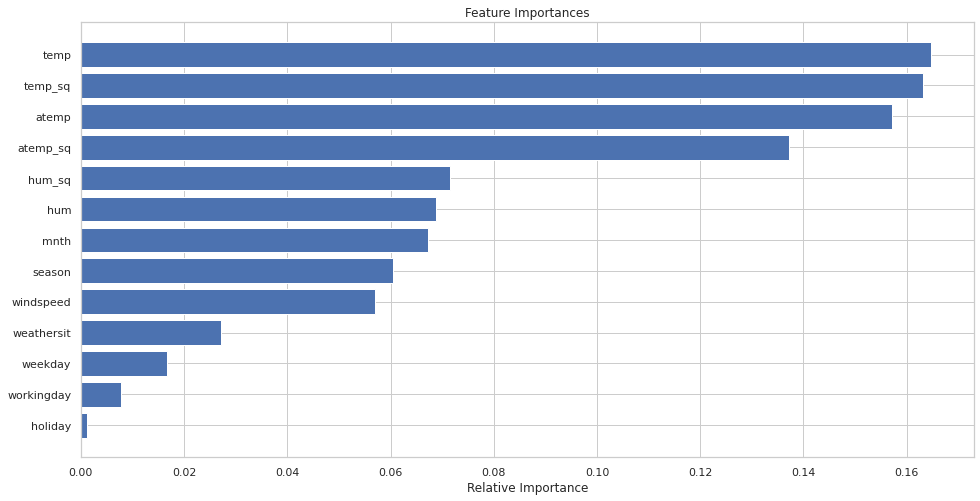

In [23]:
# Feature Importances

features = X_train_processed.columns
importances = model_cv_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Linear Model

In [24]:
# Checking highly correlated variables (above 0.8) 

corr = abs(X_train_processed.corr()).stack().reset_index().sort_values(0, ascending = False)
corr.columns = ["col1","col2","correlation"]
corr[(corr.col1 != corr.col2) & (corr.correlation > 0.8)]

,col1,col2,correlation
29,temp,atemp,0.989535
41,atemp,temp,0.989535
97,temp_sq,atemp_sq,0.989311
85,atemp_sq,temp_sq,0.989311
60,hum,hum_sq,0.986469
108,hum_sq,hum,0.986469
45,atemp,atemp_sq,0.984955
81,atemp_sq,atemp,0.984955
93,temp_sq,temp,0.984791
33,temp,temp_sq,0.984791


In [25]:
# Dropping highly correlated variables

X_train_processed2 = X_train_processed.drop(['atemp','atemp_sq','season'], axis = 1)

In [26]:
# Building a linear model

X_train_lm = sm.add_constant(X_train_processed2)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     78.26
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           1.25e-95
Time:                        20:16:02   Log-Likelihood:                -4355.9
No. Observations:                 511   AIC:                             8734.
Df Residuals:                     500   BIC:                             8780.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3372.1069    852.504     -3.956      0.0

In [27]:
# Dropping 'workingday','weekday' as they have high p-values

X_train_processed3 = X_train_processed2.drop(['workingday','weekday'], axis = 1)

In [28]:
X_train_lm = sm.add_constant(X_train_processed3)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     97.43
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           4.26e-97
Time:                        20:16:02   Log-Likelihood:                -4357.2
No. Observations:                 511   AIC:                             8732.
Df Residuals:                     502   BIC:                             8770.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3226.4467    847.492     -3.807      0.0

In [29]:
# Predictions for train set

y_train_pred = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

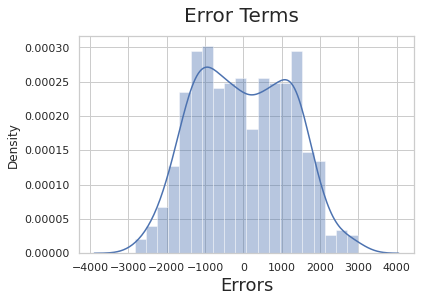

In [30]:
# Plot the histogram of the error terms

fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)

From the plot above we can observe that the error terms are somewhat normally distributed.

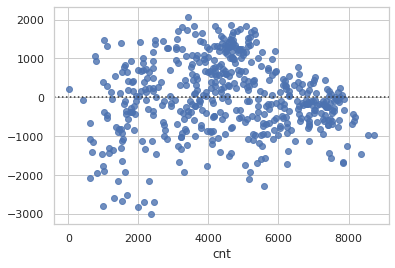

In [31]:
# Plot the residuals after fitting a linear model
sns.residplot(y_train, y_train_pred, color="b")

From the plot above we can observe that the error terms have somewhat uniform variance.

### Making predictions on Test set

In [32]:
# Dropping highly correlated variables

X_test_processed1 = X_test_processed.drop(['workingday','weekday','atemp','atemp_sq','season'], axis = 1)

In [33]:
# Adding a constant variable in X_test
X_test_lm = sm.add_constant(X_test_processed1)

# Predicting y(dependent variable) for test data set 
y_pred = lr.predict(X_test_lm)

Text(0, 0.5, 'y_pred')

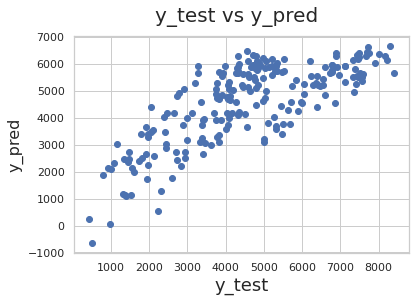

In [34]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()

plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                         
plt.ylabel('y_pred', fontsize = 16) 

In [35]:
# R2 for train set and test set

print("Train Set R2: ", round(r2_score(y_train, y_train_pred),3))
print("Test Set R2: ", round(r2_score(y_test, y_pred),3))

Train Set R2:  0.608
Test Set R2:  0.582


In [36]:
# RMSE for train set and test set
print("Train Set RMSE: ", round(mean_squared_error(y_train, y_train_pred)**0.5,2))
print("Test Set RMSE: ", round(mean_squared_error(y_test, y_pred)**0.5,2))

Train Set RMSE:  1221.43
Test Set RMSE:  1224.79


In [37]:
# Comparison of RMSE and R2 for Random forest Model vs Linear Model

# Random Forest with Grid Search|    Linear Model:
# ---------------------------------------------------------------                         
# Train Set RMSE:  784.42       |    Train Set RMSE:  1221.43
# Test Set RMSE:  1250.20       |    Test Set RMSE:  1224.79
#                               |                
# Train Set R2: 0.94            |    Train Set R2: 0.608
# Test Set R2: 0.56             |    Test Set R2: 0.582

# We can see that the RMSE and R2 on test set of Linear Model is better than Random forest model. 
# Random forest model is overfitting as the R2 on the train set is very high compared to the R2 on the test set.

# Fin!